In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import hemul
hemul.USE_FPGA=False
from hemul import heaan
from muxcnn.resnet_HEAAN import ResNetHEAAN
from muxcnn.utils import get_channel_last

from muxcnn.models.ResNet20 import ResNet, BasicBlock
from muxcnn.utils import load_params, load_img, decrypt_result
import struct

Using CPU version HEAAN
Using CPU version HEAAN
Using CPU version HEAAN


# 1. 원본 Pytorch 모델

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F

num_workers = 0
batch_size = 32
valid_size = 0.2

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

model = ResNet(BasicBlock,[1,1,1])
model.eval() 

# Load trained parameters
load_params(model, fn_param="./ResNet8.pt",device='cpu')

## FHE Setup

In [4]:
logp = 30
logq = 800
logn = 15

# Rotation 미리 준비 
rot_l = [2**i for i in range(15)]
rot_l = rot_l + [2**15-1, 
                 2**15-33, 2**15-32, 2**15-31,
                 2**15-17, 2**15-16, 2**15-15, 
                 2**15-9,2**15-8, 2**15-7] + [3,5,7,9,15,17, 31, 33]

hec = heaan.HEAANContext(logn, logp, logq, load_keys=True, rot_l=rot_l)

Initializing the scheme as the data owner
Loading a secret key from:  ./SecretKey.txt
loading secret key done.
HEAAN CKKS setup is ready 


In [5]:
fhemodel = ResNetHEAAN(model, hec, alpha=14, min_depth=True, debug=False)

# NTT - iNTT conversion

In [7]:
img_tensor, label = next(iter(valid_loader))

In [8]:
ctxt = fhemodel.pack_img_ctxt(img_tensor[:1,:,:,:])
result = fhemodel(ctxt)


[FHE_CNN] Inference started...
[FHE_CNN_EARLY] ConvBN started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
[FHE_CNN_EARLY] ConvBN finished in 6.63 sec
[FHE_CNN_EARLY] ReLU started...
bootstrap done
[DEBUG_CONVERSION] mult 140496479170928
[FHE_CNN_EARLY] ReLU hinished in 10.76 sec
[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN1 finished in 14.03 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
bootstrap done
[DEBUG_CONVERSION] mult 140499596976944
[FHE_CNN BasicBlock] ReLU1 finished in 12.99 sec
[FHE_CNN BasicBlock] ConvBN2 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN2 finished in 14.86 sec
[FHE_CNN BasicBlock] ReLU2 started...
bootstrap done
bootstrap done
[DEBUG_CONVERSION] mult 140496547779888
[FHE_CNN BasicBlock] ReLU2 finished in 13.12 sec
[FHE_CNN] First Basic Block finished in 55.03 

KeyboardInterrupt: 

### Pack and Encrypt the tensor image

In [7]:
for img_tensor, label in valid_loader:    
    print(img_tensor.shape, label)
    for i in range(2,5):
        ctxt = fhemodel.pack_img_ctxt(img_tensor[i:i+1,:,:,:])
        result = fhemodel(ctxt)

        class_num = decrypt_result(hec, result)
        print("[FHE_CNN] Inference result:", class_num)
        print(f"[FHE_CNN] It's a {classes[class_num]}, ANSWER:", label[i])
        
        del ctxt
    break

torch.Size([32, 3, 32, 32]) tensor([5, 9, 7, 1, 2, 5, 4, 6, 8, 1, 5, 4, 4, 2, 7, 3, 8, 3, 0, 1, 0, 8, 3, 2,
        4, 8, 3, 4, 5, 4, 9, 8])


In [10]:
id(ctxt)

140164743076208

In [28]:
for img_tensor, label in valid_loader:    
    print(img_tensor.shape, label)
    for i in range(2,5):
        ctxt = fhemodel.pack_img_ctxt(img_tensor[i:i+1,:,:,:])
        result = fhemodel(ctxt)

        class_num = decrypt_result(hec, result)
        print("[FHE_CNN] Inference result:", class_num)
        print(f"[FHE_CNN] It's a {classes[class_num]}, ANSWER:", label[i])
        
        del ctxt
    break

torch.Size([32, 3, 32, 32]) tensor([0, 0, 8, 9, 3, 7, 5, 0, 5, 3, 1, 0, 0, 5, 7, 7, 0, 3, 1, 3, 8, 1, 9, 5,
        4, 2, 3, 9, 1, 4, 6, 9])
[FHE_CNN] Inference started...
[FHE_CNN_EARLY] ConvBN started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
[FHE_CNN_EARLY] ConvBN finished in 7.62 sec
[FHE_CNN_EARLY] ReLU started...
bootstrap done
[FHE_CNN_EARLY] ReLU hinished in 13.43 sec
[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN1 finished in 16.99 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU1 finished in 16.08 sec
After activation <class.Ciphertext logp: 40 logq: 160 n: 32768>
FHE result: [ 1.36490976e+00  2.55309596e+00  2.09387051e+00  1.90769203e-01
  2.33915391e-01  2.18921938e-01  2.10502054e-01  2.46089640e-01
  2.28663266e-01  2.38169106e-01  3.68678106e-01  4.91165328e-01
  4.23380598e-01  3.20405917e-01  3

[FHE_CNN BasicBlock] ConvBN_shortcut finished in 20.70 sec
[forward_bb] Shortcut <class.Ciphertext logp: 40 logq: 400 n: 32768>
ctxt <class.Ciphertext logp: 40 logq: 720 n: 32768>
<class.Ciphertext logp: 40 logq: 400 n: 32768> <class.Ciphertext logp: 40 logq: 400 n: 32768>
[ 0.60831196  0.03754061 -1.04091661 ... -3.87549614 -0.92414707
 -0.24689743]
[-4.24177157 -2.21856779 -0.72639703 ...  3.05292773  1.93042076
  2.20791256]
[FHE_CNN BasicBlock] ReLU2 started...
bootstrap done
[FHE_CNN BasicBlock] ReLU2 finished in 13.45 sec
[FHE_CNN] Second Basic Block finished in 120.92 sec

bootstrap done
MuxBN bootstrap 40 800
[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(16,16,32, 2, 8,  4)
[FHE_CNN BasicBlock] ConvBN1 finished in 65.30 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
[FHE_CNN BasicBlock] ReLU1 finished in 11.83 sec
After activation <class.Ciphertext logp: 40 logq: 280 n: 32768>
FHE result: [-1.17388008e-05  2.55733131e+00 

[FHE_CNN BasicBlock] ConvBN2 finished in 15.84 sec


 ddddddd
[ 1.21041139 -1.30909169 -1.22078249 ... -1.29334982 -0.92437735
 -0.32012299]
[forward_bb] Shortcut <class.Ciphertext logp: 40 logq: 280 n: 32768>
ctxt <class.Ciphertext logp: 40 logq: 80 n: 32768>
<class.Ciphertext logp: 40 logq: 80 n: 32768> <class.Ciphertext logp: 40 logq: 80 n: 32768>
[ 1.21041139 -1.30909169 -1.22078249 ... -1.29334982 -0.92437735
 -0.32012299]
[1.80852349 0.98737218 0.98736854 ... 0.58833509 0.50692465 0.15675329]
[FHE_CNN BasicBlock] ReLU2 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU2 finished in 13.67 sec
[FHE_CNN] First Basic Block finished in 60.92 sec

[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN1 finished in 41.27 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
[FHE_CNN BasicBlock] ReLU1 finished in 12.98 sec
After activation <class.Ciphertext logp: 40 logq: 80 n: 32768>

bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU2 finished in 14.86 sec
[FHE_CNN] Third Basic Block finished in 174.92 sec

[FHE_CNN] Global AVGPool finished in 3.74 sec

[FHE_CNN] FullyConnected finished in 1.69 sec

[FHE_CNN] Inference finished in 381.48 sec

[FHE_CNN] Inference result: 5
[FHE_CNN] It's a dog, ANSWER: tensor(9)
[FHE_CNN] Inference started...
[FHE_CNN_EARLY] ConvBN started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
[FHE_CNN_EARLY] ConvBN finished in 7.16 sec
[FHE_CNN_EARLY] ReLU started...
bootstrap done
[FHE_CNN_EARLY] ReLU hinished in 12.35 sec
[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN1 finished in 15.80 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU1 finished in 14.63 sec
After activation <class.Ciphertext logp: 40 logq: 160 n: 32768>
FHE result: [ 1.83430120e+00  2.91305313e+00

bootstrap done
[FHE_CNN BasicBlock] ReLU2 finished in 13.43 sec
[FHE_CNN] Second Basic Block finished in 121.24 sec

bootstrap done
MuxBN bootstrap 40 800
[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(16,16,32, 2, 8,  4)
[FHE_CNN BasicBlock] ConvBN1 finished in 64.59 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
[FHE_CNN BasicBlock] ReLU1 finished in 11.33 sec
After activation <class.Ciphertext logp: 40 logq: 280 n: 32768>
FHE result: [-4.28844491e-05  2.59278154e+00  3.27923873e-06  2.63290717e+00
 -2.30999357e-06  2.08994548e+00  2.19316699e-05  1.29544966e+00
 -2.55529972e-06 -9.50660328e-06 -1.01081286e-05  2.72843119e+00
 -5.42446375e-05 -1.32200593e-05 -8.41982819e-06  3.09596537e+00
  3.83712116e-06 -3.72606584e-06 -4.34488152e-06  3.84668961e+00
  1.61134541e-05 -1.52231725e-05 -1.33742881e-05  2.69965144e+00
 -1.37017802e-05 -4.66993219e-06 -1.25253534e-05  2.39675990e+00
  4.52149222e-06  2.18417661e-06  1.40818287e-05

In [8]:
hec.decrypt(result)[:20]

array([-57.71915988, -62.6038506 , -60.16777689, -60.21411586,
       -60.21411586, -47.02503475, -47.91369151, -47.20886079,
       -47.20886079, -47.68459379, -47.68429555, -47.68429555,
       -30.07955556, -29.5941355 , -29.94816603, -29.93506537,
       -31.21940504, -31.23914996, -31.14747462, -34.89492681])

In [11]:
out1 = model.activation(model.bn1(model.conv1(img_tensor[1:2,])))

In [23]:
out1[0][0].ravel()[:300]

tensor([1.9926, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.3622, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0141, 0.0106, 0.1075, 0.0384, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 2.3268, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0403,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.3212, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [18]:
model.debug(img_tensor[1:2,:,:,:])

DEBUG 1 tensor([[[[1.9926, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [2.3622, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [2.3268, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [2.0475, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.9907, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.5690, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 1.5173, 0.7715,  ..., 0.9453, 0.4447, 0.0000],
          [0.0000, 2.4063, 1.4528,  ..., 1.2524, 0.6442, 0.0000],
          [0.0000, 2.3665, 1.4371,  ..., 1.0912, 0.5696, 0.0000],
          ...,
          [0.0000, 1.1475, 0.5807,  ..., 1.0355, 1.1042, 0.2263],
          [0.0000, 1.5418, 0.7969,  ..., 1.5402, 1.2705, 0.3664],
          [0.6761, 0.6984, 0.5954,  ..., 0.7252, 0.7180, 0.0779]],

         [[1.7506, 0.0000, 0.0542,  ..., 0.8996, 1.2072, 0.0000],
          [2.6453, 0.0000, 0.6279,  ..., 0.9757, 1.4267, 0.7408],
          [2.7021, 0.0000, 0.5723,

tensor([[-6.4733e+00, -1.2888e+01, -1.1673e-02, -6.2074e+00, -5.9588e+00,
         -8.7177e+00, -5.2575e+00, -1.1052e+01, -9.6897e+00, -1.1412e+01]],
       grad_fn=<LogSoftmaxBackward0>)

In [18]:
step1= model.conv1(img_tensor)
step2 = model.bn1(step1)

In [19]:
step3 = model.layer1(step2)

# 2. Cehck Ciphertext 

### 2.1. save Ciphertext to file

In [9]:
heaan.he.SerializationUtils.writeCiphertext(ctxt, "packed_img.dat")

### 2.2 Load using Python 

In [84]:
import struct

f = open("packed_img.dat", "rb")
encrypted_img = f.read()

data = struct.iter_unpack('l', encrypted_img[:8*3]) # Ctxt header
read_nslots, read_logp, read_logq = data

print("Ciphertext has the following FHE parameters:")
print("nslots, logp, logq  = ", read_nslots, read_logp, read_logq)

Ciphertext has the following FHE parameters:
nslots, logp, logq  =  (32768,) (40,) (800,)


### 2.3. Try to interpret encrypted data

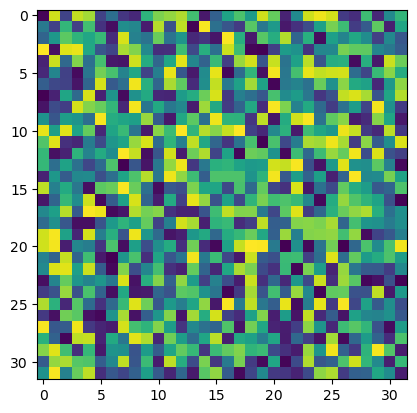

In [85]:
arr = np.frombuffer(encrypted_img[8*3:], dtype=np.int64)
reshaped = arr.reshape(32,32,-1)
plt.imshow(reshaped[:,:,0])